### Диагностика неисправностей коробки передач

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fft, signal, stats
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
from tqdm.notebook import tqdm
from sklearn import preprocessing 
from sklearn import linear_model 
from sklearn import metrics 
from sklearn import tree 
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import StackingClassifier
import optuna
from sklearn import model_selection

c:\Users\LOPLAKSINA\Anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


## О данных

Описание набора данных включает следующие детали:

Набор данных диагностики неисправностей коробки передач включает в себя набор данных о вибрации, записанных с помощью
симулятора диагностики неисправностей коробки передач SpectraQuest.
Набор данных был записан с использованием 4 датчиков вибрации, размещенных в четырех разных направлениях, при 
изменении нагрузки от «0» до «90» процентов. Включены два разных сценария:

1) Бездефектное состояние

2) Сломанный зуб

Набор данных содержит 2 файла.
Всего было сделано 20 видов записей, 10 на "здоровую" коробку передач и 10 на сломанную. Каждый вид записи 
соответствует заданной нагрузке от 0% до 90% с шагом 10%.

Имя файла указывает на содержимое файла:
broken и healthy - соответвенно записи для коробки со сломаным зубом и для бездефектной коробки.  
Каждое имя файла на конце содержит символы «30hz». Мы можем интерпретировать это как означающее, что данные о 
вибрации были собраны с частотой данных 30 Гц. 
Это дает нам информацию о продолжительности сбора данных в каждом наборе 
(т.е. количество выборок / 30 = время в секундах), а также позволяет нам интерпретировать данные как непрерывный 
сигнал и анализировать данные не только в частотной области, но и во временной области.

Для работы с этими наборами данных мы можем объединить показания в один набор данных.

In [2]:
df_h=pd.read_csv('healthy30hz.csv')
df_b=pd.read_csv('broken30hz.csv')
df=df_h.merge(df_b, how='outer')
df['sample_index']=df.index

In [3]:
df.sample(3, random_state=42)

,a1,a2,a3,a4,failure,load,sample_index
1583597,2.24030,-0.033332,-3.621630,-3.72461,1.0,50.0,1583597
1197075,2.35699,0.125734,0.324272,-1.21394,1.0,10.0,1197075
17675,2.87033,0.755489,1.448250,-1.49890,0.0,0.0,17675


Для работы с этим набором данных мы можем преобразовать показания в такой набор данных, где наблюдения находятся в одном столбце, помеченном датчиком, нагрузкой и состоянием коробки передач.

In [4]:
sensor_readings = df.melt(
    id_vars=['sample_index','failure','load'],
    value_vars=['a1','a2','a3','a4'],
    var_name='sensor',
    value_name='reading'
)

In [5]:
sensor_readings.head()

,sample_index,failure,load,sensor,reading
0,0,0.0,0.0,a1,4.636710
1,1,0.0,0.0,a1,1.992800
2,2,0.0,0.0,a1,-3.764110
3,3,0.0,0.0,a1,-4.558710
4,4,0.0,0.0,a1,0.575382


**Описание получившихся столбцов:**

- sample_index - номер отсчета при измерении вибрации;
- failure - индикатор, который указывает сломан ли зуб или нет (0 - не сломан, 1 - сломан);
- load - нагрузка;
- sensor - обозначение датчика (их всего 4);
- reading - значение амплитуды колебаний;

## Разведывательный анализ

Начнем со стандартного анализа набора данных.

Сколько отсчетов в каждом файле?

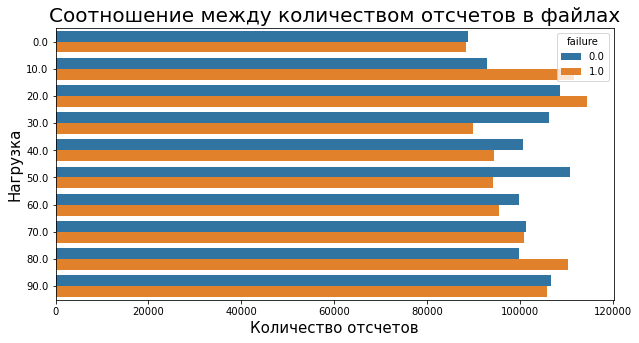

In [6]:
fig = plt.figure(figsize=(10, 5))
countpl= sns.countplot(
    data=sensor_readings[sensor_readings.sensor=='a1'],
    y='load',
    hue='failure'
    )
countpl.set_title('Соотношение между количеством отсчетов в файлах', fontsize=20)
countpl.set_xlabel('Количество отсчетов', fontsize=15)
countpl.set_ylabel('Нагрузка', fontsize=15);

Все файлы имеют примерно одинаковое количество сэмплов (~90-120 тыс. сэмплов на файл). Какое наименьшее число и что это означает с точки зрения времени?

In [7]:
#Какой набор имеет наименьшее количество образцов
lowest_samples = df.groupby(['failure','load'])['sample_index'].count().min()
print(f'Наименьшее количество сэмплов = {lowest_samples}')
print(f'Перевод в {lowest_samples/30:0.2f} секунды или {lowest_samples/30/60:0.2f} минуты')

Наименьшее количество сэмплов = 88320
Перевод в 2944.00 секунды или 49.07 минуты


Каждый файл имеет как минимум 49 минут активной вибрации.

### Анализ во временной области

Как выглядят данные с одного датчика?

<Figure size 720x1080 with 0 Axes>

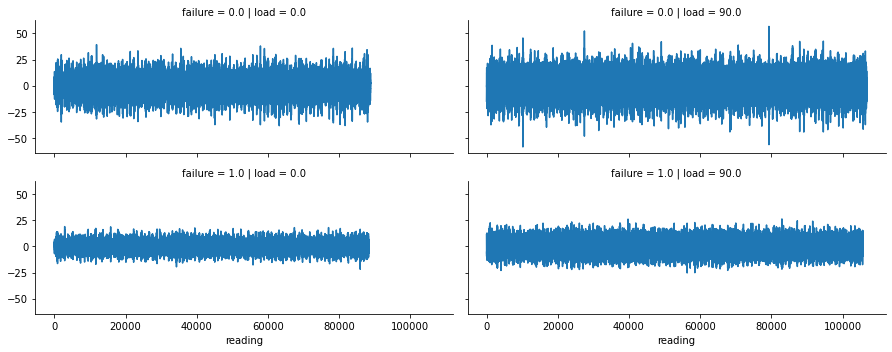

In [8]:
fig = plt.figure(figsize=(10, 15))
g = sns.FacetGrid(
    data=pd.concat([
        sensor_readings[(sensor_readings['load']==0) & (sensor_readings['sensor']=='a1')],
        sensor_readings[(sensor_readings['load']==90) & (sensor_readings['sensor']=='a1')]
    ]),
    col='load',
    row='failure',
    height=2.5,
    aspect=2.5
)
g.map(plt.plot, 'reading')
plt.show()

Похоже, есть разница в амплитуде между показаниями датчика на здоровой коробке передач и на той, у которой сломан зуб.

Это так во всех записях?

Мы можем использовать диаграмму boxenplot, чтобы показать распределение показаний и сравнить между собой исправную и сломанную коробки передач для одной и той же нагрузки и датчика.

Теперь мы можем использовать функцию seaborn catplot, чтобы разбить данные по нагрузке, датчику и состоянию, а также построить график распределения показаний в каждой группе.

Каждая строка — это отдельный датчик, каждый столбец - увеличение нагрузки
На каждом графике показано распределение значений показаний между исправной и неисправной коробкой передач


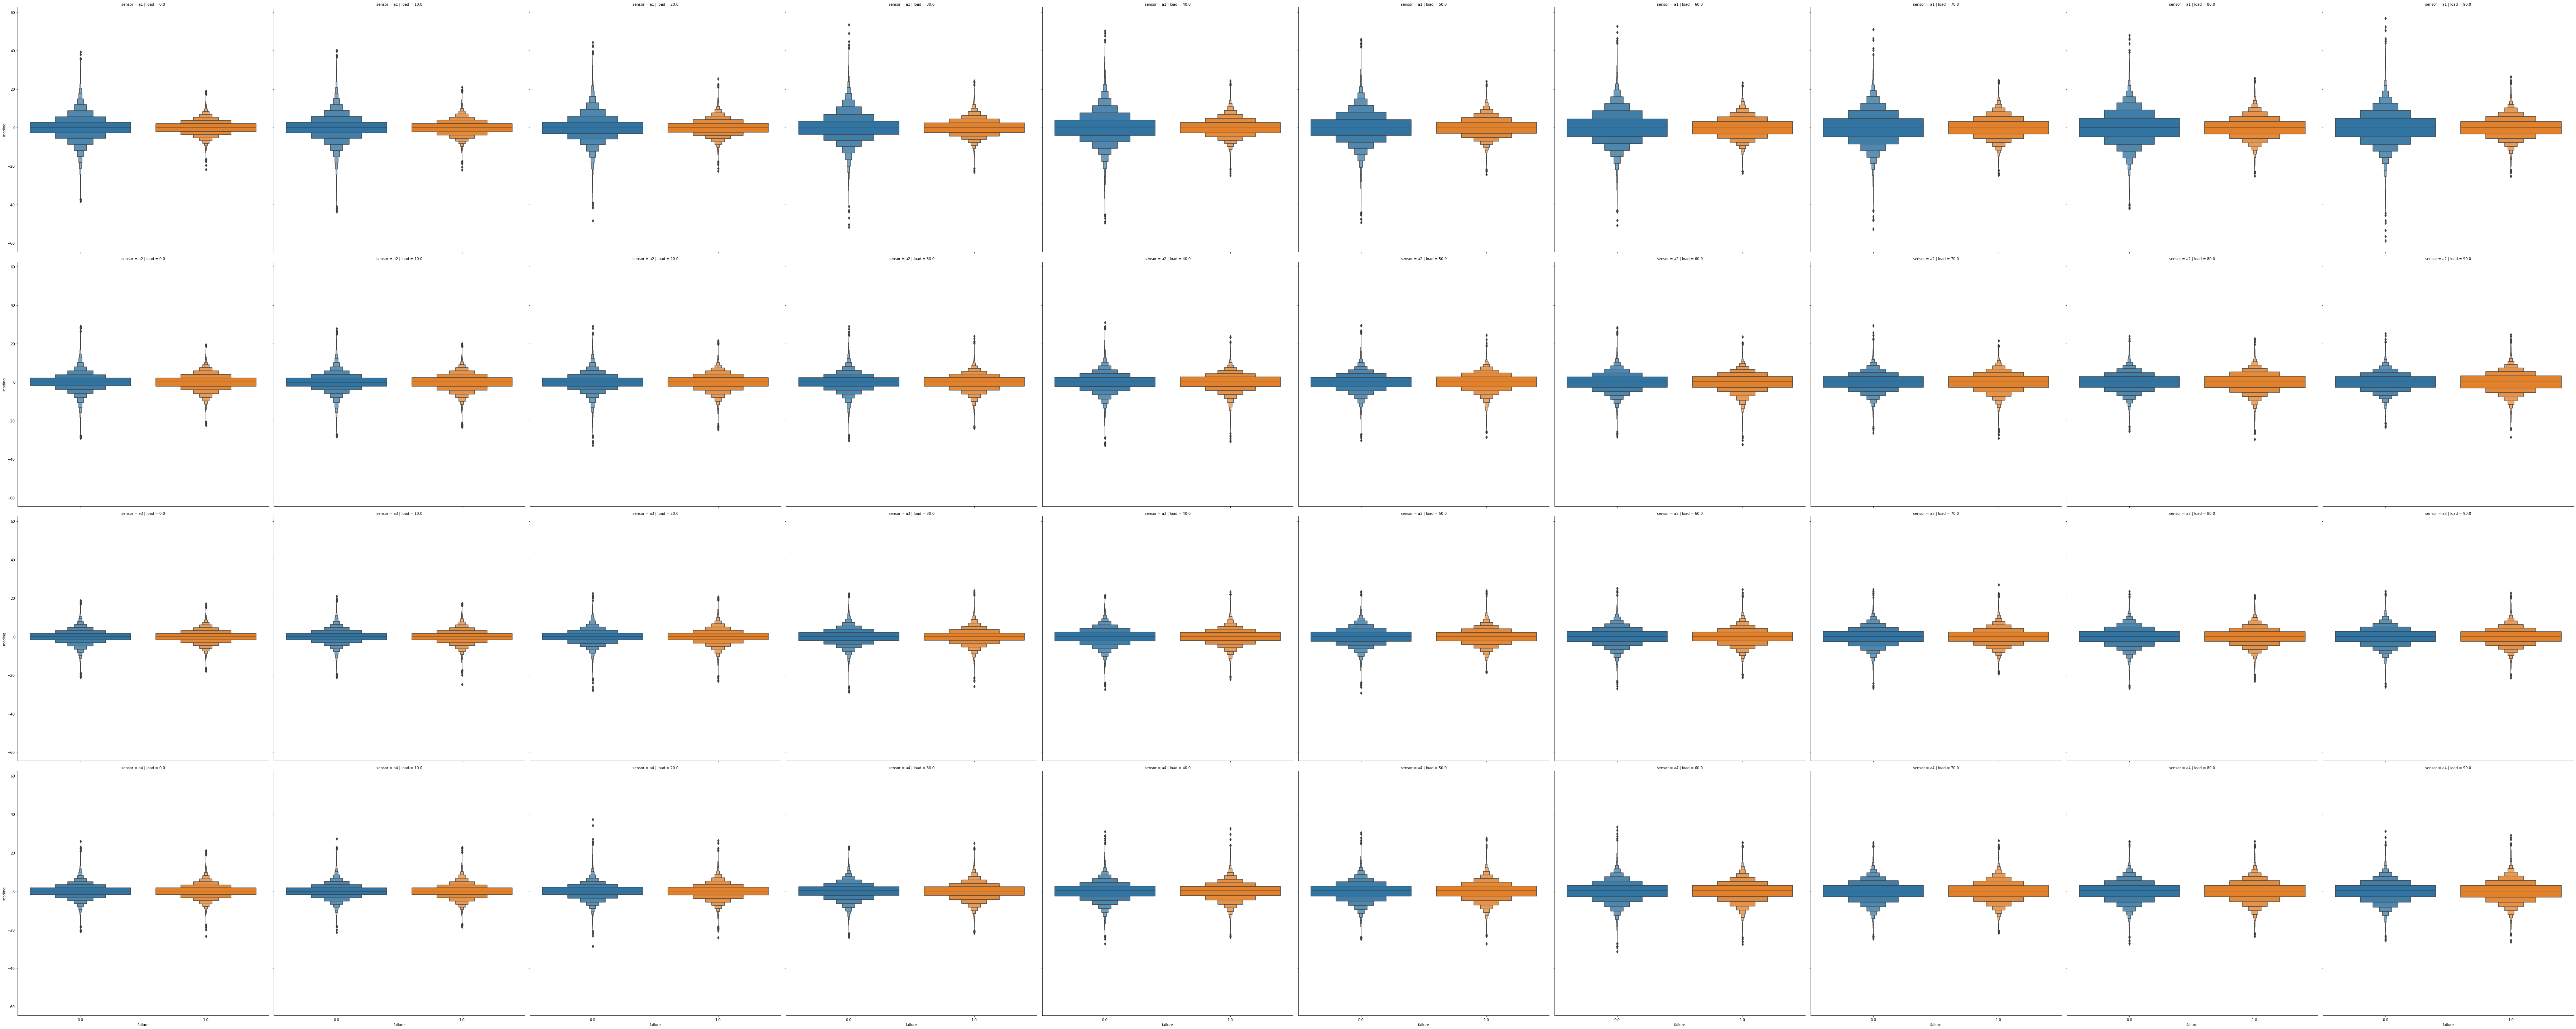

In [9]:
print('Каждая строка — это отдельный датчик, каждый столбец - увеличение нагрузки')
print('На каждом графике показано распределение значений показаний между исправной и неисправной коробкой передач')
sns.catplot(
    data=sensor_readings,
    col='load', row='sensor',
    x='failure', y='reading',
    kind='boxen',
    height=10
)

Похоже, что на датчике a1 разница амплитуд гораздо больше, чем у других, и она увеличивается по мере увеличения нагрузки. В датчике a2 также есть небольшая видимая разница, но не такая большая. Различия между датчиками а3 и а4 не кажутся существенными. Такая разница может быть из за места установки датчика а1 или, возможно, у «здоровой» коробки передач была какая-то другая проблема, которая вызывала увеличение амплитуды показаний.

Давайте посмотрим на общее распределение амплитуд для всех датчиков. Для корректности данных важно, чтобы распределение было нормальным или близким к нормальному.

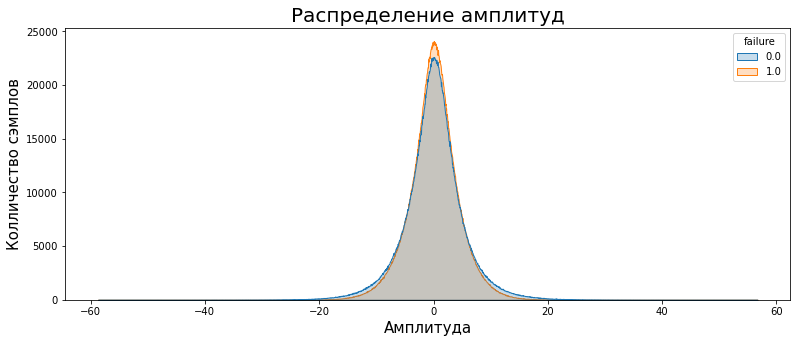

In [10]:
plt.figure(figsize=(13,5))
histpl=sns.histplot(
    data=sensor_readings,
    hue='failure',
    x='reading',
    element="poly"
)
histpl.set_title('Распределение амплитуд', fontsize=20)
histpl.set_xlabel('Амплитуда', fontsize=15)
histpl.set_ylabel('Колличество сэмплов', fontsize=15);
plt.show()

Давайте посмотрим, что произойдет с распределением, если мы рассмотрим только датчики a2, a3 и a4.

In [11]:
display(sensor_readings.groupby(['sensor','failure']).reading.std().unstack())
print(f"Стандартное отклонение, включая датчик a1: {sensor_readings.reading.std()}")
print(f"Стандартное отклонение без датчика a1: {sensor_readings[sensor_readings.sensor!='a1'].reading.std()}")

failure,0.0,1.0
sensor,,
a1,7.381206,4.602696
a2,4.427153,4.389516
a3,4.110277,3.808909
a4,4.523553,4.408367


Стандартное отклонение, включая датчик a1: 4.822152445519395
Стандартное отклонение без датчика a1: 4.285349925978674


Исключение датчика a1 определенно приводит к изменению набора данных.

In [12]:
#сброс показаний с датчика a1
readings = sensor_readings[sensor_readings.sensor!='a1']

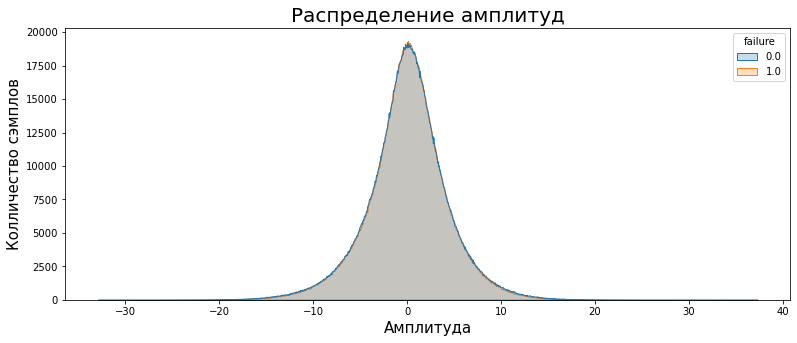

In [13]:
plt.figure(figsize=(13,5))
histp=sns.histplot(
    data=readings,
    hue='failure',
    x='reading',
    element="poly"
)
histp.set_title('Распределение амплитуд', fontsize=20)
histp.set_xlabel('Амплитуда', fontsize=15)
histp.set_ylabel('Колличество сэмплов', fontsize=15);
plt.show()

### Анализ в частотной области

Полезно смотреть на данные о вибрации во времени, но вибрации возникают на разных частотах — это очень сложно определить с помощью временного анализа. Частотный анализ данных может дать некоторые более ощутимые признаки.

Частотный анализ использует преобразования Фурье для преобразования данных сигнала (например, показаний вибрации) в его составляющие частоты. Начнем с показаний одного датчика.

Посмотрим на спектр сигнала одного из датчиков для редуктора со сломанным зубом и для бездефектного редуктора.

In [14]:
sensor_data_b = sensor_readings[(sensor_readings['failure']==1) & (sensor_readings['load']==10) & (sensor_readings['sensor']=='a4')].reading.values
sensor_data_h = sensor_readings[(sensor_readings['failure']==0) & (sensor_readings['load']==10) & (sensor_readings['sensor']=='a4')].reading.values

Text(0, 0.5, 'Амплитуда')

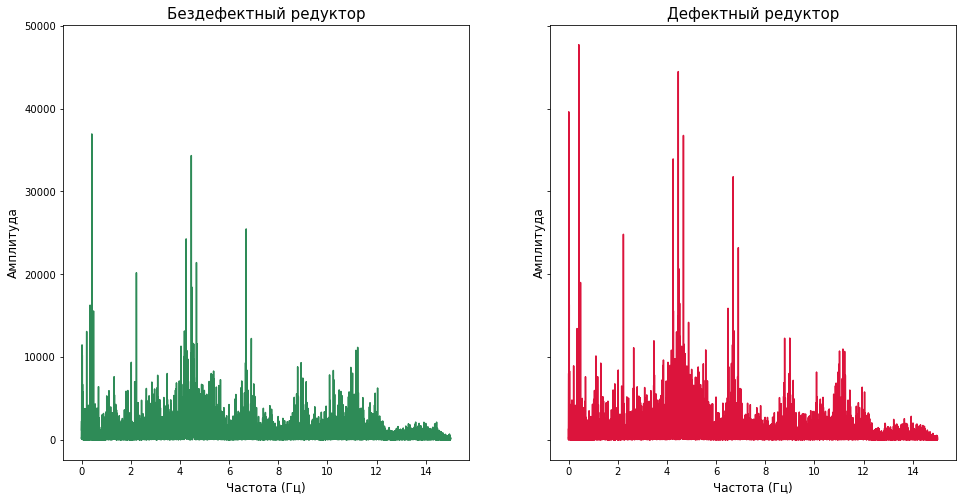

In [15]:
y_b = np.abs(fft.rfft(sensor_data_b))
y_h = np.abs(fft.rfft(sensor_data_h))
x_b= fft.rfftfreq(sensor_data_b.shape[0], 1/30)  # 30Гц частота дискретизации
x_h= fft.rfftfreq(sensor_data_h.shape[0], 1/30)  # 30Гц частота дискретизации

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(16,8))
ax1, ax2 = axes.flatten()
ax1.plot(x_h, y_h, 'seagreen')
ax1.set_xlabel('Частота (Гц)', fontsize=12)
ax1.set_ylabel('Амплитуда', fontsize=12)
ax1.set_title('Бездефектный редуктор', fontsize=15)

ax2.plot(x_b, y_b, 'crimson')
ax2.set_title('Дефектный редуктор', fontsize=15)
ax2.set_xlabel('Частота (Гц)', fontsize=12)
ax2.set_ylabel('Амплитуда', fontsize=12)

Мы видим некоторые пики на спектре. Посмотрим, сможем ли мы идентифицировать эти пики:

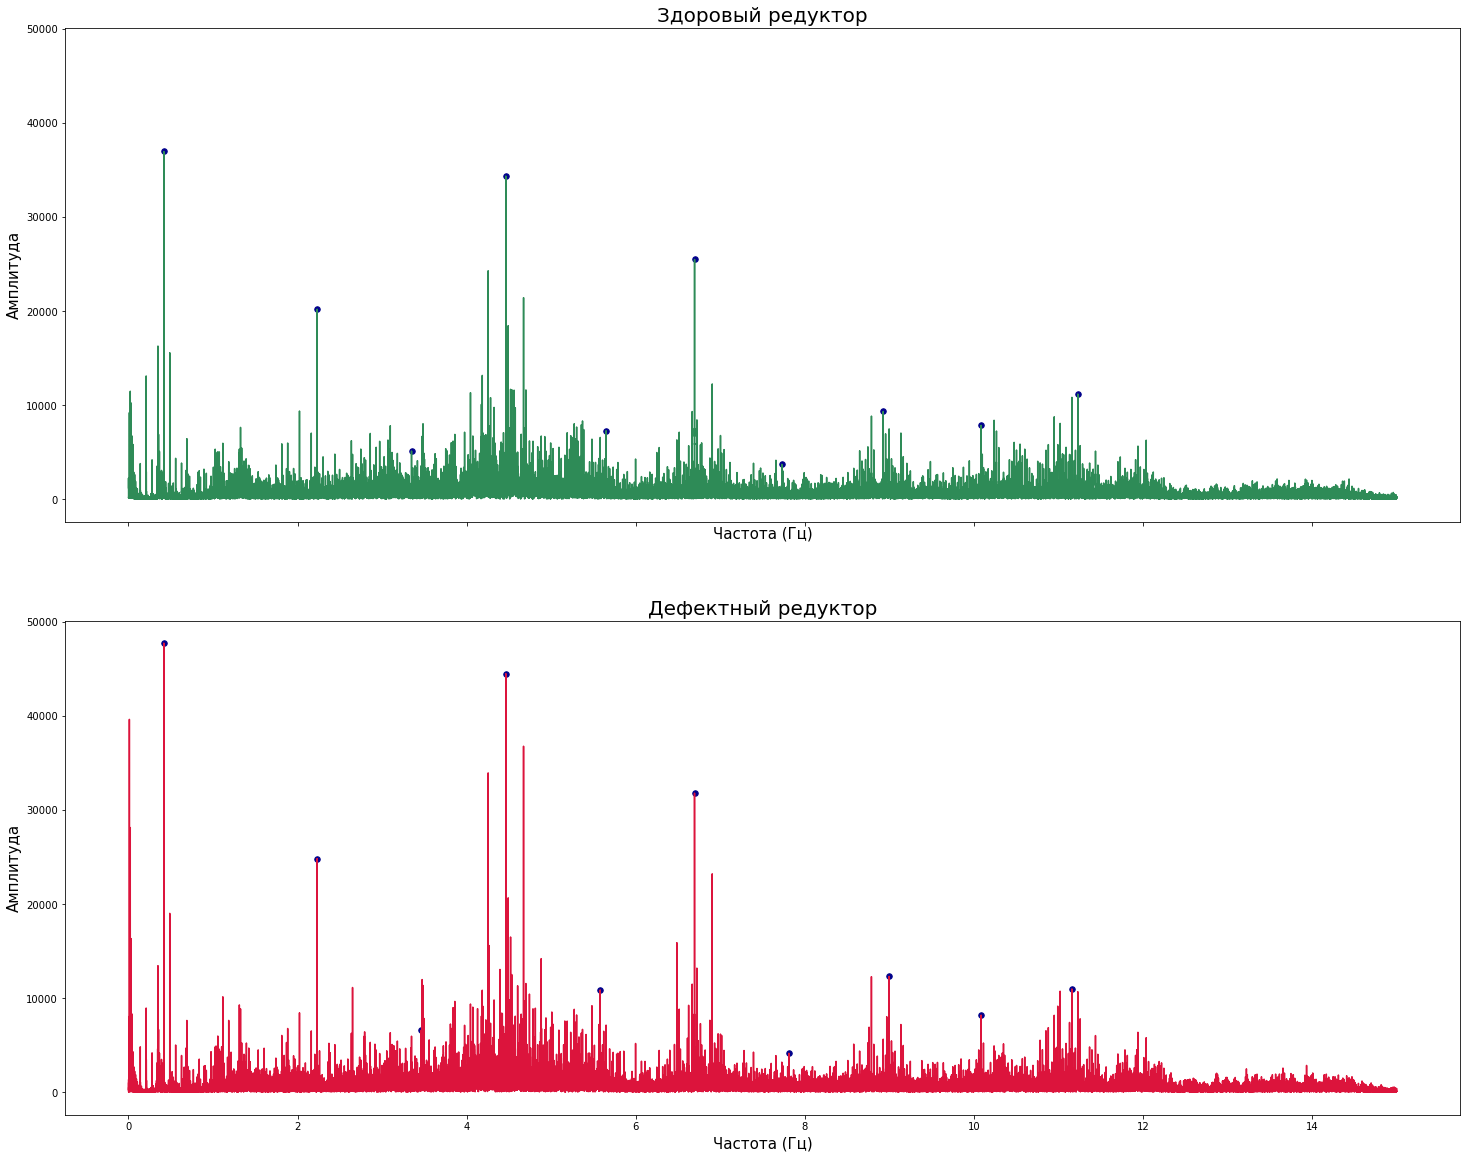

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(25,20))
ax1, ax2 = axes.flatten()
ax1.plot(x_h, y_h, 'seagreen')

# Найдем пики, которые находятся на расстоянии не менее 1 Гц друг от друга (количество точек частоты / максимальную частоту)
x_peak_spacing_h = y_h.shape[0] / x_h.max()

# Выше окружающих значений на 99-й процентиль значений
x_peak_prominence_h = np.quantile(y_h,0.99)

peaks_h, _ = signal.find_peaks(y_h, distance=x_peak_spacing_h, prominence=x_peak_prominence_h)

for peak in peaks_h:
    ax1.scatter(x=x_h[peak], y=y_h[peak], c='darkblue', marker='o', s=30)
ax1.set_xlabel('Частота (Гц)', fontsize=15)
ax1.set_ylabel('Амплитуда', fontsize=15)
ax1.set_title('Здоровый редуктор', fontsize=20)


ax2.plot(x_b, y_b,'crimson')
x_peak_spacing_b = y_b.shape[0] / x_b.max()
x_peak_prominence_b = np.quantile(y_b,0.99)

peaks_b, _ = signal.find_peaks(y_b, distance=x_peak_spacing_b, prominence=x_peak_prominence_b)

for peak in peaks_b:
    ax2.scatter(x=x_b[peak], y=y_b[peak], c='darkblue', marker='o', s=30)
ax2.set_title('Дефектный редуктор', fontsize=20)
ax2.set_xlabel('Частота (Гц)', fontsize=15)
ax2.set_ylabel('Амплитуда', fontsize=15);

In [17]:
data={'Частота здоровый':[x_h[peak] for peak in peaks_h],'Амплитуда здоровый':[y_h[peak] for peak in peaks_h],'Частота дефектный':[x_b[peak] for peak in peaks_b],'Амплитуда дефектный':[y_b[peak] for peak in peaks_b]}
peak= pd.DataFrame(data)
peak.head(10)

,Частота здоровый,Амплитуда здоровый,Частота дефектный,Амплитуда дефектный
0,0.418388,36942.247711,0.418488,47714.797888
1,2.231728,20189.030335,2.231669,24830.812334
2,3.347753,5135.143822,3.462676,6606.121445
3,4.463456,34331.337924,4.463339,44468.815098
4,5.649212,7285.022561,5.579308,10876.587919
5,6.695506,25475.940995,6.695008,31775.200594
6,7.727596,3719.204544,7.810977,4149.526110
7,8.927234,9336.256828,8.996560,12309.995711
8,10.084904,7860.523948,10.084576,8203.296031
9,11.228693,11185.976417,11.158615,10982.135925


Итак, разберем по порядку. Редуктор состоит из нескольких кинематических элементов, которые и будут давать основную вибрацию. Это как правило: зубчатые передачи, подшипники и валы. Характерные частоты подшипников и зубчатых передач лежат в области более высоких частот, нежели, чем частота самого вала. Поэтому первый самый большой пик на частоте 0.42 Гц можно отнести к частоте вращения. Судя по увеличению амплитуды оборотной частоты на спектре дефектного редуктора относительно здорового на 22,5%, можно сказать о присутствии дисбаланса на валу. И это понятно, ведь у нашего зубчатого колеса сломан зуб. А колесо сидит на этом валу, следовательно, неравномерное распределение массы колеса при вращении и будет вызывать этот дисбаланс. Далее, мы видим явные гармоники с интервалами 2,23 Гц (2,23, 4,46, 6,70 и т. д.). Скорей всего, это частоты от зубчатого колеса. У них большая энергия (амплитуда) даже у безефектного колеса, что вполне объяснимо, ведь энергия передаваемая от захода в зацепление зубов будет больше, чем, например от перекатывания шариков по дорожкам качения подшипника. Здесь мы также видим увеличение амплитуды на спектре дефектного редуктора этих частот, что тоже вполне логично, ведь из-за того, что один зуб сломан, соседнему приходится выдерживать повышенную нагрузку.
Наконец, мы видим на спектре еще одно "семейство" частот: пики с интервалами между ними (3,35, 5,65, 7,73 и т. д.). Это уже скорей всего подшипниковые частоты. Их амплитуда на спектре дефектного редуктора, конечно, тоже возросла относительно бездефектного, но все же не так сильно. Это говорит о том, что зуб сломан не так давно и этот дефект еще не успел в полной мере отразиться на подшипнике.

Другой вид анализа — это спектральная плотность мощности. Это более наглядное представление о характере сигнала.

Построим график СПМ для каждого датчика при каждой нагрузке и сравним сигналы исправного и неисправного редуктора. Мы также можем сопоставить значения мощности для каждой частоты между исправной и неисправной коробками передач, чтобы увидеть, насколько хорошо они совпадают.

Корреляция между двумя спектрами показана в названии каждого графика.

  0%|          | 0/40 [00:00<?, ?it/s]

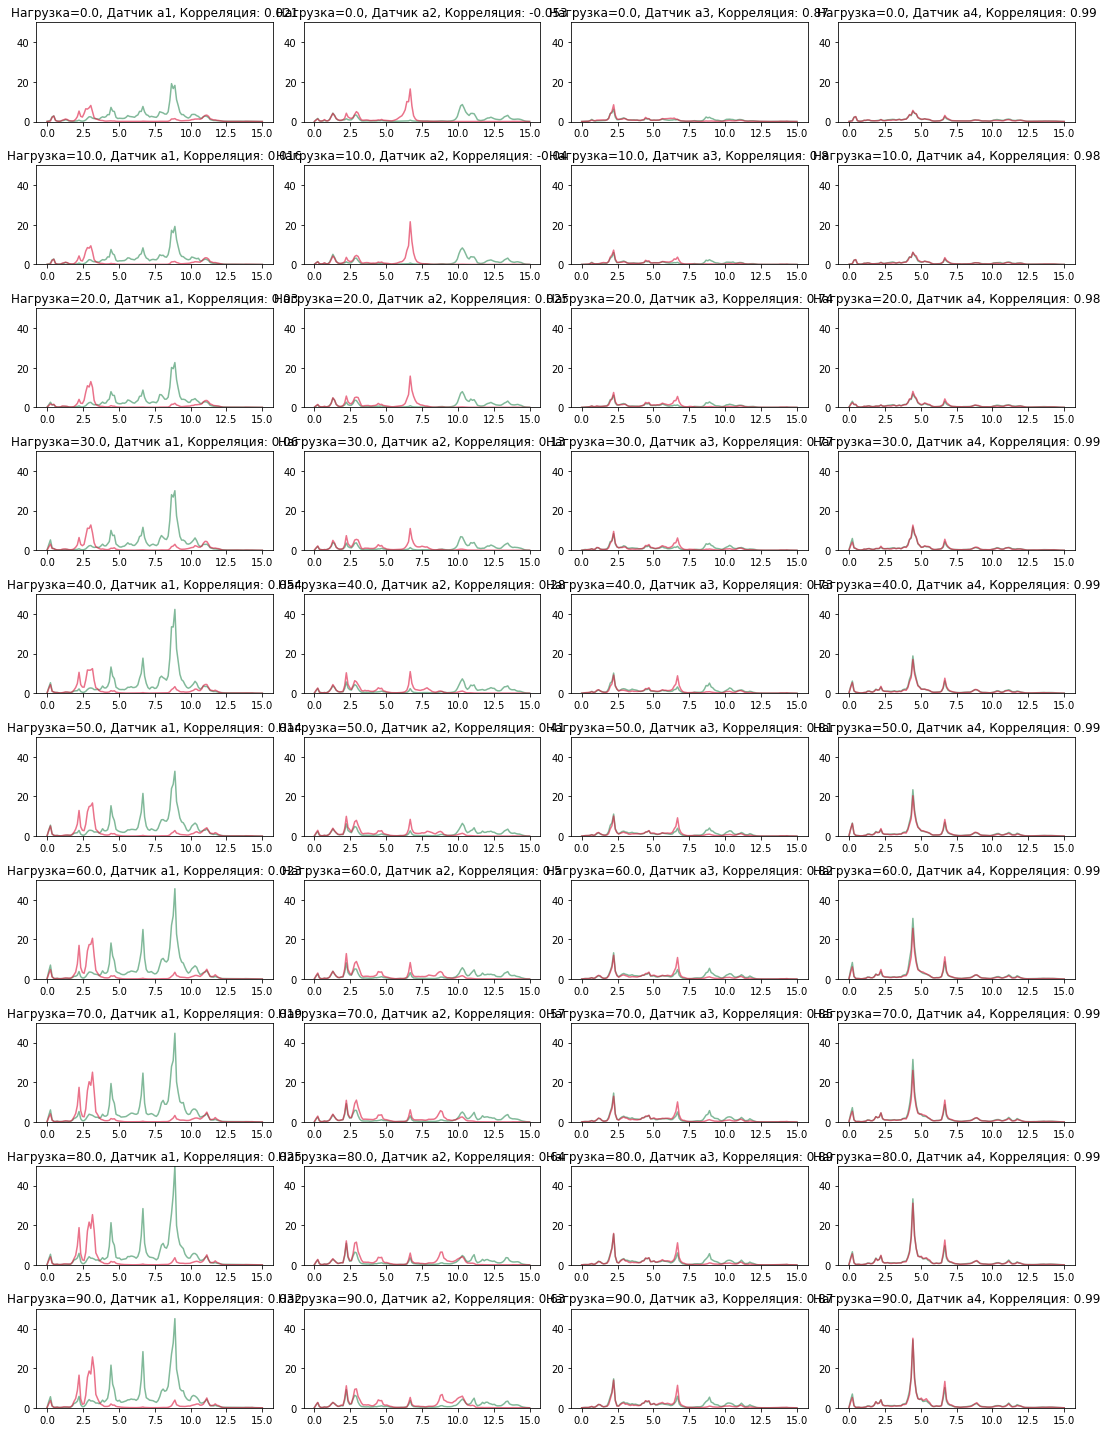

In [18]:
fig, ax = plt.subplots(ncols=4, nrows=10, figsize=(15,20))
for ((load,sensor), dfg), axi in tqdm(zip(sensor_readings.groupby(['load','sensor']), ax.ravel()), total=40):
    healthy_raw = dfg[dfg.failure==0].reading.values
    broken_raw = dfg[dfg.failure==1].reading.values
    
    fh, Ph = signal.welch(healthy_raw, fs=30)
    fb, Pb = signal.welch(broken_raw, fs=30)

    axi.plot(fh, Ph, c='seagreen', alpha=0.6)
    axi.plot(fb, Pb, c='crimson', alpha=0.6)
    axi.set_ylim(0,50)
    axi.set_title(f'Нагрузка={load}, Датчик {sensor}, Корреляция: {np.corrcoef(Ph, Pb)[0,1]:0.2}')
plt.tight_layout()
plt.show()

Здесь видно, что в то время как корреляция СПМ датчика а4 почти не отличается, корреляция СПМ для других датчиков показывает заметные различия. Для датчиков а1, а2 и а3 мощность сигнала на более высоких частотах значительно ниже в показаниях редуктора со сломанным зубом. Эта закономерность видна при всех нагрузках. Это объясняется тем, что развитый дефект, как правило, "переносит" часть энергии из области высоких в область более низких частот. 

Посмотрим, изменится ли спектр со временем. Сделаем это с помощью спектрографа.

  0%|          | 0/80 [00:00<?, ?it/s]

C:\Users\LOPLAK~1\AppData\Local\Temp/ipykernel_12876/3807156982.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axi.pcolormesh(t, f, Sxx, cmap='nipy_spectral')


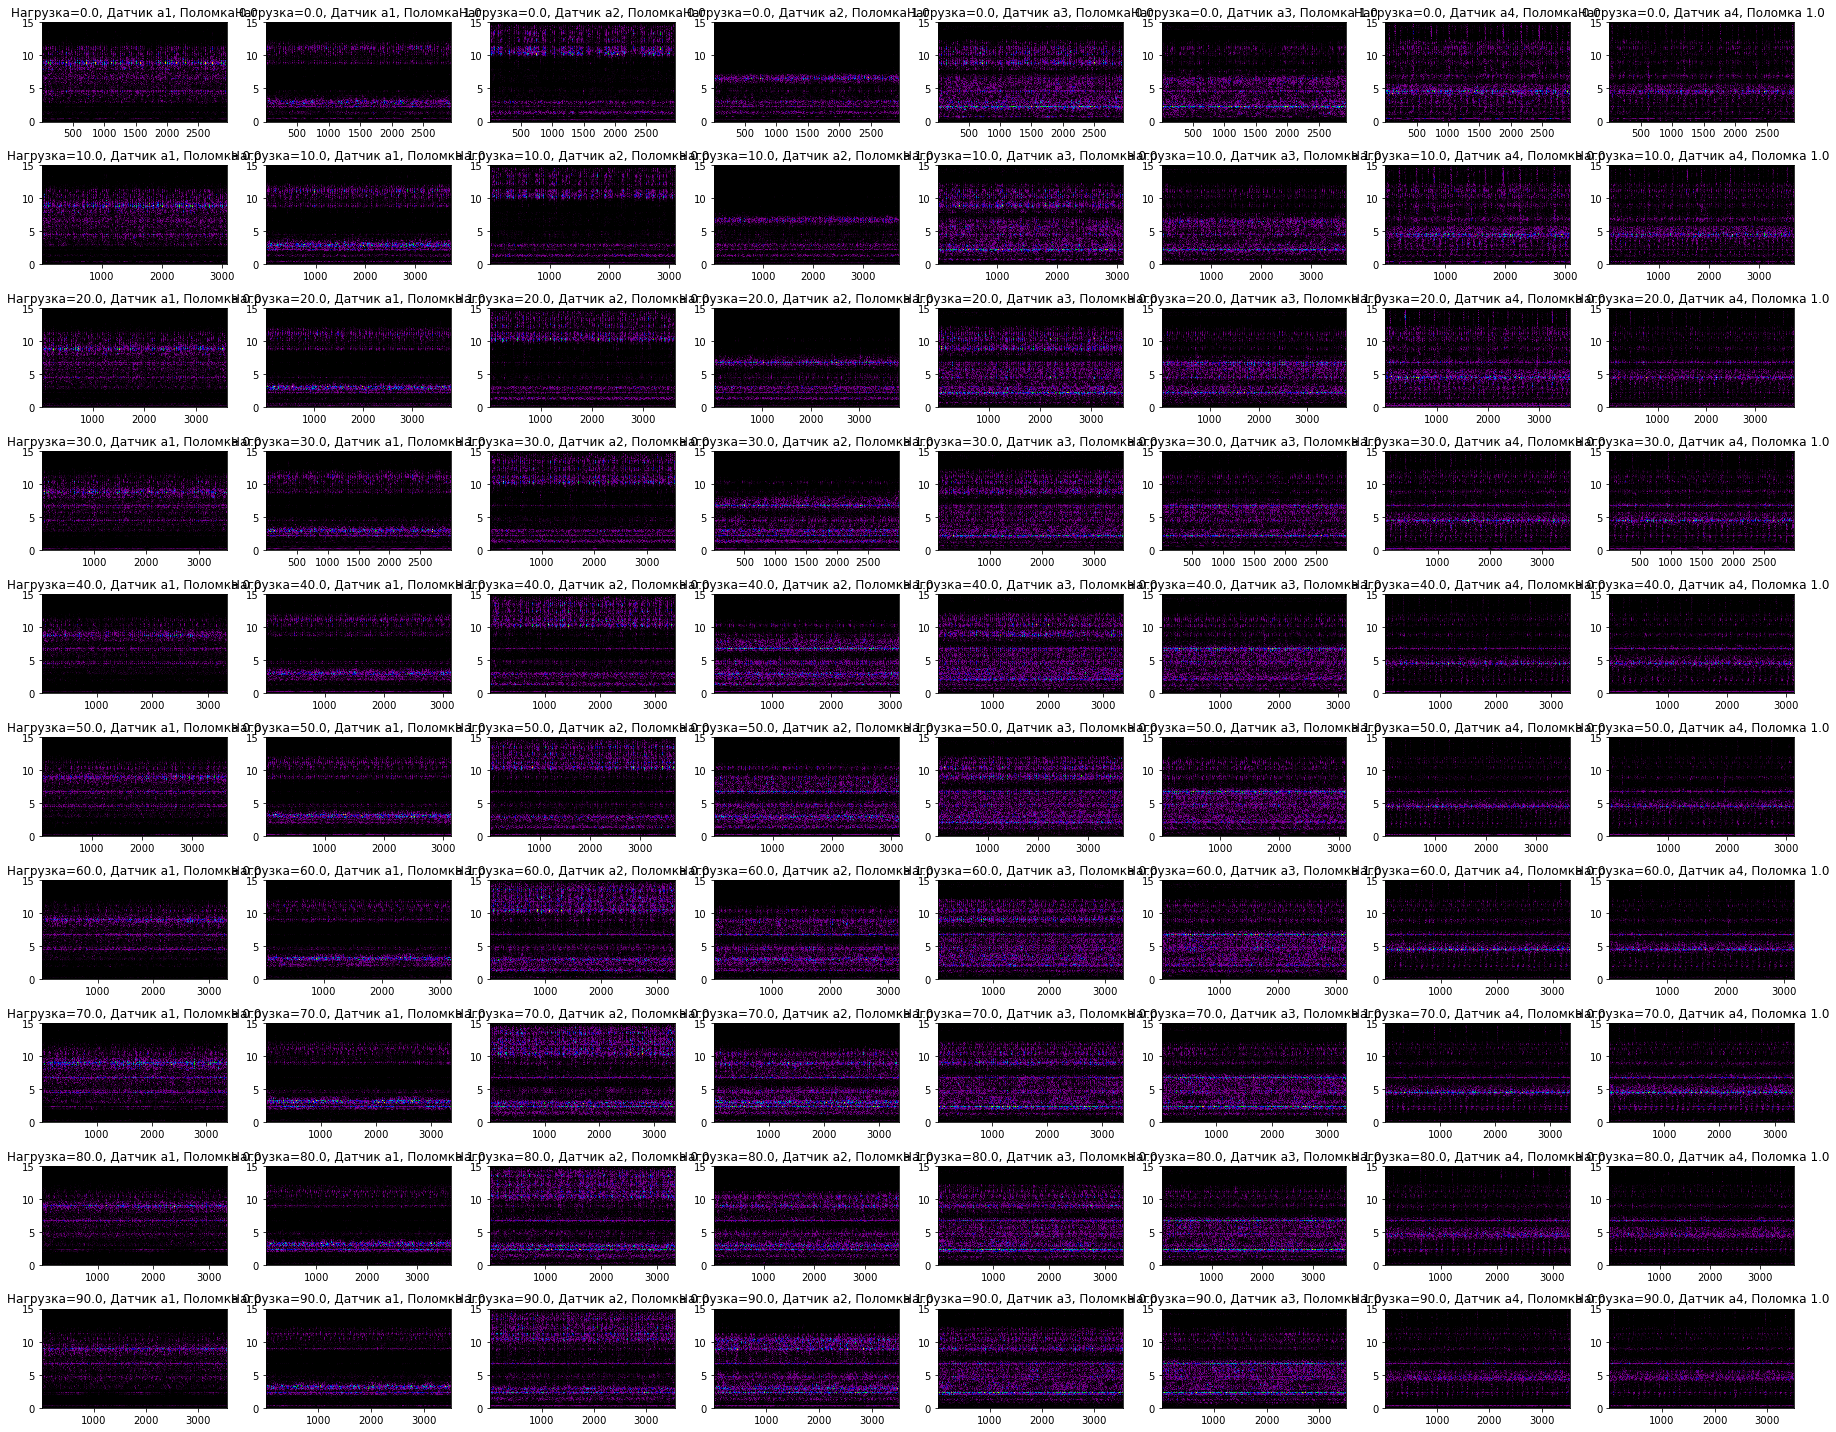

In [19]:
fig, ax = plt.subplots(ncols=8, nrows=10, figsize=(25,20))
for ((load, sensor, failure), dfg), axi in tqdm(zip(sensor_readings.groupby(['load','sensor','failure']), ax.ravel()), total=80):
    raw = dfg.reading.values
    f, t, Sxx = signal.spectrogram(raw, fs=30) 
    axi.pcolormesh(t, f, Sxx, cmap='nipy_spectral')
    axi.set_title(f'Нагрузка={load}, Датчик {sensor}, Поломка {failure}')
plt.tight_layout()
plt.show()


Спектры не меняются со временем. Это значит, что не происходит ухудшения дефекта (к примеру, не ломаются другие зубы). Энергия распределена равномерно по всей частоте (цвет с течением времени не меняется).

## Применение ML

Итак, у нас есть чистый набор данных и мы можем приступить к изучению подхода машинного обучения, который сможет различать вибрации здоровой коробки передач и вибрации коробки передач со сломанным зубом.

Определим и создадим функции для каждого образца.

In [20]:
data = []
labels = []
for (failure,load,sensor),g in sensor_readings.groupby(['failure','load','sensor']):
    vals = g.reading.values
    splits = np.split(vals, range(1,vals.shape[0],1000))
    for s in splits: 
        data.append({
            'sensor_a1': int(sensor=='a1'),
            'sensor_a2': int(sensor=='a2'),
            'sensor_a3': int(sensor=='a3'),
            'sensor_a4': int(sensor=='a4'),
            'load': load,
            'mean': np.mean(s),
            'std': np.std(s),
            'kurt': stats.kurtosis(s),
            'skew': stats.skew(s)
        })
        labels.append(int(failure))  # единичная метка указывает на неисправность

df_data = pd.DataFrame(data)
data = df_data.values
labels = np.array(labels)
(data.shape, labels.shape)

((8196, 9), (8196,))

In [21]:
# Посмотрим что получилось
df_data.head(10)

,sensor_a1,sensor_a2,sensor_a3,sensor_a4,load,mean,std,kurt,skew
0,1,0,0,0,0.0,4.636710,0.000000,-3.000000,0.000000
1,1,0,0,0,0.0,-0.024410,5.546124,2.633036,0.026451
2,1,0,0,0,0.0,-0.022941,6.208450,3.615781,-0.045223
3,1,0,0,0,0.0,-0.053569,5.108584,3.561368,-0.154210
4,1,0,0,0,0.0,-0.041423,5.787193,1.556972,-0.041282
5,1,0,0,0,0.0,-0.022636,6.121546,2.140481,0.064763
6,1,0,0,0,0.0,-0.052522,5.506862,2.028341,0.126760
7,1,0,0,0,0.0,-0.020872,5.314810,3.291625,-0.147278
8,1,0,0,0,0.0,-0.068225,5.551795,2.117365,0.119968
9,1,0,0,0,0.0,-0.041322,5.701321,3.220121,-0.094077


In [22]:
print(f'Всего сэмплов: {len(labels)}')
print(f'Сэмплов со сломанным зубом: {np.sum(labels)} ({np.sum(labels)/len(labels):0.1%})')

Всего сэмплов: 8196
Сэмплов со сломанным зубом: 4080 (49.8%)


Разделим набор данных на обучающий набор данных и тестовый набор данных.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    data, labels,
    train_size=0.8,
    random_state=42,
    stratify=labels
)
print(f'Размер тренировочного набора: {X_train.shape}')
print(f'Размер тестового набора: {X_test.shape}')

Размер тренировочного набора: (6556, 9)
Размер тестового набора: (1640, 9)


In [24]:
# нормализуем данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Решение задачи классификации

Начнем с логистической регрессии

In [25]:
# Обучим логистическую регрессию и рассчитаем метрики качества
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [26]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      3292
           1       0.70      0.72      0.71      3264

    accuracy                           0.70      6556
   macro avg       0.70      0.70      0.70      6556
weighted avg       0.71      0.70      0.70      6556

              precision    recall  f1-score   support

           0       0.74      0.68      0.71       824
           1       0.70      0.76      0.73       816

    accuracy                           0.72      1640
   macro avg       0.72      0.72      0.72      1640
weighted avg       0.72      0.72      0.72      1640



Попробуем увеличить метрики с помощью более продвинутого метода ML: решающие деревья.

In [27]:
# обучим решающие деревья, настроив максимальную глубину
# Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

In [28]:
#Делаем предсказание для тренировочной выборки
y_train_pred = dt.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = dt.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      3292
           1       0.77      0.73      0.75      3264

    accuracy                           0.75      6556
   macro avg       0.75      0.75      0.75      6556
weighted avg       0.75      0.75      0.75      6556

              precision    recall  f1-score   support

           0       0.72      0.80      0.76       824
           1       0.77      0.69      0.73       816

    accuracy                           0.74      1640
   macro avg       0.75      0.74      0.74      1640
weighted avg       0.75      0.74      0.74      1640



In [29]:
# подберем оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3,5,7]
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid,  
    n_jobs = -1
)  

%time grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

Wall time: 6.55 s
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 5}


In [30]:
# обучим решающие деревья, настроив параметры после их подбора с помощью  gridsearch
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    min_samples_split=5,
    max_depth=7,
    random_state=42
)
dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=5,
                       random_state=42)

In [31]:
#Делаем предсказание для тренировочной выборки
y_train_pred = dt.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = dt.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      3292
           1       0.78      0.76      0.77      3264

    accuracy                           0.78      6556
   macro avg       0.78      0.78      0.78      6556
weighted avg       0.78      0.78      0.78      6556

              precision    recall  f1-score   support

           0       0.74      0.81      0.77       824
           1       0.78      0.71      0.75       816

    accuracy                           0.76      1640
   macro avg       0.76      0.76      0.76      1640
weighted avg       0.76      0.76      0.76      1640



Конечно, метрика улучшилась, но все же попробуем решить задачу классификации с помощью ансамблей моделей и построим прогноз

In [32]:
# Обучим на наших данных случайный лес
# Создаем объект класса случайный лес
random_forest = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    min_samples_leaf = 5,
    max_depth=10, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
random_forest.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_pred = random_forest.predict(X_test_scaled)
#Выводим отчет о метриках
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       824
           1       0.86      0.84      0.85       816

    accuracy                           0.86      1640
   macro avg       0.86      0.86      0.86      1640
weighted avg       0.86      0.86      0.86      1640



In [33]:
# используем для классификации градиентный бустинг и сравним качество со случайным лесом

gb = GradientBoostingClassifier(
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    min_samples_leaf=5, #минимальное число значений в классе
    max_depth=5, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
gb.fit(X_train_scaled, y_train)
y_pred = gb.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       824
           1       0.86      0.84      0.85       816

    accuracy                           0.86      1640
   macro avg       0.86      0.86      0.86      1640
weighted avg       0.86      0.86      0.86      1640



Качество обученной модели при помощи случайного леса такое же как и при помощи градиентного бустинга

In [34]:
# объединим уже известные нам алгоритмы с помощью стекинга 
estimators = [
    ('dt', 
     tree.DecisionTreeClassifier(
         criterion='entropy',
         max_depth=7,
         min_samples_leaf=5,
         random_state=42
     )),
    ('log_reg',
     linear_model.LogisticRegression(
         solver='sag',
         max_iter=1000,
         random_state=42
     )),
    ('gb',
     ensemble.GradientBoostingClassifier(
         learning_rate=0.05,
         n_estimators=300,
         min_samples_leaf=5,
         max_depth=5,
         random_state=42
     ))
]

#Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=ensemble.RandomForestClassifier(n_estimators=100,
                                          criterion='gini',
                                          min_samples_leaf = 5,
                                          max_depth=10, 
                                          random_state=42)
)

#Обучаем модель
reg.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       min_samples_leaf=5,
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=RandomForestClassifier(max_depth=10,
                                                          min_samples_leaf=5,
                                                          random_state=42))

In [35]:
y_pred = reg.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       824
           1       0.86      0.84      0.85       816

    accuracy                           0.85      1640
   macro avg       0.85      0.85      0.85      1640
weighted avg       0.85      0.85      0.85      1640



In [36]:
# реализуем оптимизацию гиперпараметров для случайного леса с помощью Optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [37]:
%%time
# cоздаем объект исследования
# напрямую укажем, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-02-10 00:50:47,518] A new study created in memory with name: RandomForestClassifier
[I 2023-02-10 00:50:49,668] Trial 0 finished with value: 0.9783176995232971 and parameters: {'n_estimators': 152, 'max_depth': 18, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9783176995232971.
[I 2023-02-10 00:50:52,081] Trial 1 finished with value: 0.9306991819725267 and parameters: {'n_estimators': 155, 'max_depth': 17, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9783176995232971.
[I 2023-02-10 00:50:54,188] Trial 2 finished with value: 0.9449668567905041 and parameters: {'n_estimators': 172, 'max_depth': 15, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9783176995232971.
[I 2023-02-10 00:50:56,203] Trial 3 finished with value: 0.9120098795924668 and parameters: {'n_estimators': 186, 'max_depth': 17, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9783176995232971.
[I 2023-02-10 00:50:58,122] Trial 4 finished with value: 0.9255483472350943 and parameters: {'n_

Wall time: 36.7 s


In [38]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 102, 'max_depth': 23, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [39]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.86
f1_score на тестовом наборе: 0.86


Метрики улучшились по сравнению с предыдущими моделями.

Для того, чтобы еще раз убедиться в правильности выбора модели обучения выполним интеллектуальный поиск среди моделей машинного обучения, которые подходят для задачи классификации. Сделаем это с помощью TPOTClassifier.

In [64]:
%%time
tpot_td = TPOTClassifier(generations=5, random_state=42, max_time_mins=1)
tpot_td.fit(X_train, y_train)
print(f'Best accuracy score: {tpot_td.score(X_test, y_test):0.3%}')

Best accuracy score: 86.402%
Wall time: 1min 16s


c:\Users\LOPLAKSINA\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py:765: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(


Выведем список моделей, которые были оценены в процессе оптимизации. Посмотрим, какая модель по мнению TPOT подходит сюда наилучшим образом.

In [65]:
pd.Series([
    model.split('(')[0]
    for model in tpot_td.evaluated_individuals_.keys()
]).value_counts()

RandomForestClassifier    4
BernoulliNB               4
XGBClassifier             3
ExtraTreesClassifier      3
DecisionTreeClassifier    2
SGDClassifier             2
GaussianNB                1
KNeighborsClassifier      1
MLPClassifier             1
LinearSVC                 1
LogisticRegression        1
dtype: int64

И все же это случайный лес.

Проведем эксперимент

Возьмем нашу разделенную выборку на тренировочную и тестовую.

Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и считать среднее значение метрики по фолдам).

Итого мы будем использовать три показателя:

значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);

значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).

Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.

Так как в сочетании сложность модели и метрика "победил" случайный лес, то проведем эксперимент именно с ним.

In [42]:
#Создаём объект кросс-валидатора k-fold со стратификацией
skf = model_selection.StratifiedKFold(n_splits=5)

In [43]:
#Считаем метрики на кросс-валидации k-fold со стратификацией
cv_metrics = model_selection.cross_validate(
    estimator=model, #модель
    X=X_train, #матрица наблюдений X
    y=y_train, #вектор ответов y
    cv=skf, #кросс-валидатор
    scoring='f1', #метрика
    return_train_score=True #подсчёт метрики на тренировочных фолдах
)
 
print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 0.99
Valid k-fold mean f1: 0.86


In [54]:
#Создаём список из моделей
models = [
    ensemble.RandomForestClassifier(
    n_estimators=102, 
    max_depth=5,
    min_samples_leaf=2,
    random_state=42 
),
    ensemble.RandomForestClassifier(
    n_estimators=102, 
    max_depth=7,
    min_samples_leaf=2,
    random_state=42 
),
    ensemble.RandomForestClassifier(
    n_estimators=102, 
    max_depth=23,
    min_samples_leaf=2,
    random_state=42 
),
        ensemble.RandomForestClassifier(
    n_estimators=102, 
    max_depth=7,
    min_samples_leaf=5,
    random_state=42 
),
    ensemble.RandomForestClassifier(
    n_estimators=102, 
    max_depth=7,
    min_samples_leaf=7,
    random_state=42 
),
    ensemble.RandomForestClassifier(
    n_estimators=102, 
    max_depth=7,
    min_samples_leaf=10,
    random_state=42 
)
]

In [55]:
def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring="f1",  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

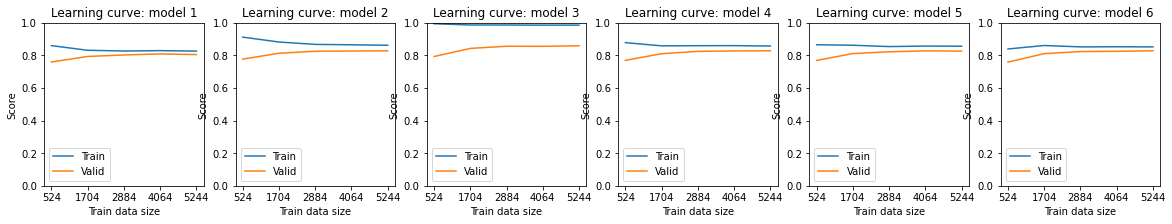

In [56]:
#Визуализируем кривые обучения
fig, axes = plt.subplots(1, 6, figsize=(20, 3)) #фигура + три координатных плоскости
#Создаём цикл по списку моделей и индексам этого списка
for i, model in enumerate(models): #i — текущий индекс, model — текущая модель
    plot_learning_curve(model, X_train, y_train, skf, ax=axes[i], title=f'model {i+1}')

Из всех представленных оптимальной является модель, кривая обучения которой изображена на втором графике. Тренировочная и валидационная кривые постепенно сходятся к единой отметке качества, и полученная метрика превышает отметку в 0.5.

In [57]:
model=ensemble.RandomForestClassifier(
    n_estimators=102, #число деревьев
    max_depth=7, #максимальная глубина дерева
    min_samples_leaf=2,
    random_state=42 #генератор случайных чисел
)

In [58]:
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_leaf=2, n_estimators=102,
                       random_state=42)

In [59]:
y_test_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       824
           1       0.83      0.83      0.83       816

    accuracy                           0.83      1640
   macro avg       0.83      0.83      0.83      1640
weighted avg       0.83      0.83      0.83      1640



In [60]:
#Делаем предсказание вероятностей на кросс-валидации
y_cv_proba_pred = model_selection.cross_val_predict(model, X_train, y_train, cv=skf, method='predict_proba')
#Выделяем столбец с вероятностями для класса 1 
y_cv_proba_pred = y_cv_proba_pred[:, 1]

In [61]:
#Вычисляем координаты PR-кривой
precision, recall, thresholds = metrics.precision_recall_curve(y_train, y_cv_proba_pred)

print('Thresholds:', thresholds[:5])
print('Precision scores:', precision[:5])
print('Recall scores:',recall[:5])

Thresholds: [0.00156588 0.00187101 0.00208414 0.00210506 0.00216748]
Precision scores: [0.49786455 0.4979405  0.49801648 0.49809248 0.4981685 ]
Recall scores: [1. 1. 1. 1. 1.]


Best threshold = 0.49, F1-Score = 0.83


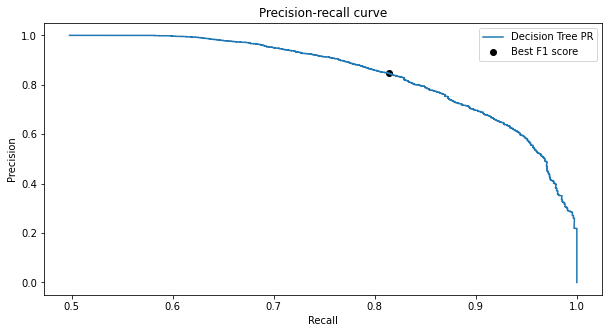

In [62]:
#Вычисляем F1-score при различных threshold
f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))
 
#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(precision, recall, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(precision[idx], recall[idx], marker='o', color='black', label='Best F1 score')
#Даём графику название и подписываем оси
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();

In [63]:
y_test_pred_proba = model.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_pred_proba > 0.49).astype('int')
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       824
           1       0.81      0.84      0.83       816

    accuracy                           0.83      1640
   macro avg       0.83      0.83      0.83      1640
weighted avg       0.83      0.83      0.83      1640



**Вывод:**

Можно сказать, что предварительный подбор гиперпараметров для модели, определенным образом улучшает ее качество. Но даже подбор гиперпараметров нужно осуществлять с помощью современных методов, таких как Hyperopt или Optuna например. Это существенно уменьшает время на подборку гиперпараметров базовыми методами, такими как GridSearchCV. Впринципе, как и методы подбора гиперпараметров, так и виды обучаемых моделей будут для каждой задачи свои, поэтому по возможности, нужно все таки стремиться обучить как можно больше моделей разными методами, сравнивая их метрики. Только так, мы найдем как оптимальную модель, так и оптимальный метод подбора гиперпараметров этой модели.